### AIM: test/develop workflow for BORUTA feature selection

In [5]:
from boruta import BorutaPy
import pandas as pd
import numpy as np
import mne
import pickle

from sklearn.ensemble import RandomForestClassifier

In [6]:
df_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_features.pkl')
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

,ID,age,gender,diagnosis,epoch,EO_frontal_delta_std,EO_frontal_delta_mean,EO_frontal_delta_median,EO_frontal_delta_skew,EO_frontal_delta_kurt,...,ratio_parietal_gamma_std,ratio_parietal_gamma_mean,ratio_parietal_gamma_median,ratio_parietal_gamma_skew,ratio_parietal_gamma_kurt,ratio_occipital_gamma_std,ratio_occipital_gamma_mean,ratio_occipital_gamma_median,ratio_occipital_gamma_skew,ratio_occipital_gamma_kurt
5517,sub-88054357,61,0.0,MDD,10,0.429419,-0.191763,-0.181902,-0.312801,-0.173242,...,1.093848,1.146366,1.193708,1.068157,0.690963,1.020670,1.016421,1.020109,1.128782,1.114820
7181,sub-88071093,24,0.0,OCD,6,0.385438,-0.145052,-0.140149,-0.679093,1.367643,...,0.762010,0.489248,0.495263,-3.426373,0.522221,0.752161,0.485270,0.481451,-4.182683,0.368883
5453,sub-88054129,30,0.0,ADHD,6,0.371051,-0.142532,-0.143707,-0.393526,-0.119291,...,0.994120,0.997166,0.902982,0.888536,0.420313,0.967034,0.964403,0.924664,0.837971,0.590439
3820,sub-88040185,23,1.0,ADHD,5,0.437629,-0.209571,-0.185229,-0.227506,-0.131910,...,0.971659,0.911444,1.009387,1.147670,0.766345,0.902112,0.790014,0.702005,1.460237,1.181544
439,sub-87968089,64,1.0,SMC,8,0.428404,-0.191359,-0.185835,-0.321896,0.021614,...,0.976644,0.962914,0.972037,0.829450,0.538708,0.979057,0.934080,0.808671,2.054087,3.854643
1194,sub-87976773,<NA>,0.0,HEALTHY,7,0.399456,-0.171086,-0.163661,-0.262764,0.411092,...,1.104034,1.183675,1.196094,1.285390,2.471737,1.069812,1.142022,1.325549,1.007754,1.255215
421,sub-87968045,57,0.0,SMC,2,0.329358,-0.123288,-0.116525,-0.191665,0.346326,...,1.039986,1.078678,1.104701,0.934814,0.781763,1.108870,1.171448,1.165261,1.399428,2.327795


In [7]:
# subsample dataset to rebalance dataset
df_ids = df_features[(df_features['epoch'] == 1)] # select only first epoch to make sure we subsample from participants, and not from epochs
df_ids_subsample = df_ids.groupby('diagnosis').sample(45, random_state=42) # sample 45 participants per diagnosis (which is the max for OCD)
df_ids_subsample_index = df_ids_subsample['ID'].tolist()
df_subsample = df_features[(df_features['ID'].isin(df_ids_subsample_index))]
df_subsample['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [8]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_features_ec = df_subsample[df_features.columns[~(df_subsample.columns.str.startswith('EO') | df_subsample.columns.str.startswith('ratio'))]]
df_features_eo = df_subsample[df_features.columns[~(df_subsample.columns.str.startswith('EC') | df_subsample.columns.str.startswith('ratio'))]]
df_features_ratio = df_subsample[df_features.columns[~(df_subsample.columns.str.startswith('EC') | df_subsample.columns.str.startswith('EO'))]]

In [9]:
# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

### Ratio features

In [34]:
# define numeric columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_ratio[numeric_cols]
Y = df_features_ratio['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [35]:
X_ratio_selected = pd.DataFrame(data=feature_selection,
                          columns=df_features_ratio[numeric_cols].columns[trans.support_])
X_ratio_selected

,ratio_frontal_delta_std,ratio_frontal_delta_mean,ratio_frontal_delta_median,ratio_frontal_delta_skew,ratio_central_delta_skew,ratio_parietal_delta_skew,ratio_frontal_theta_std,ratio_frontal_theta_mean,ratio_frontal_theta_median,ratio_frontal_theta_kurt,...,ratio_parietal_gamma_std,ratio_parietal_gamma_mean,ratio_parietal_gamma_median,ratio_parietal_gamma_skew,ratio_parietal_gamma_kurt,ratio_occipital_gamma_std,ratio_occipital_gamma_mean,ratio_occipital_gamma_median,ratio_occipital_gamma_skew,ratio_occipital_gamma_kurt
0,0.897143,0.830481,0.837335,0.922125,1.107686,1.019826,0.934562,0.909492,0.890494,0.493470,...,0.968281,1.022076,1.052374,0.469458,0.126383,1.051424,1.123622,1.156979,0.866754,1.785548
1,1.125661,1.197514,1.261229,1.095214,1.021300,1.105398,1.044091,1.012339,1.003071,1.796595,...,0.994825,0.998219,1.003191,0.944901,1.384317,1.020286,1.098013,1.087812,0.544720,0.002118
2,1.104341,1.178697,1.120514,1.050109,1.186433,1.714988,1.074149,1.086153,1.074447,-0.987755,...,1.071320,1.153472,1.159519,0.889397,1.053610,1.156190,1.299332,1.286826,1.068119,0.834607
3,1.179867,1.395611,1.523042,0.391307,0.364732,1.273961,1.183072,1.505453,1.661458,-0.132499,...,0.924726,0.751021,0.873962,4.524715,1.097089,0.956484,0.916655,1.080320,0.780077,0.596561
4,1.082619,1.190399,1.227287,0.620114,0.771762,0.522016,1.201699,1.663324,1.648302,-0.236259,...,1.132596,1.413028,1.312625,0.472916,1.821612,1.133601,1.252463,1.128770,1.247167,1.738256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.922396,0.812560,0.821697,1.242942,1.974557,6.723829,1.109027,1.211630,1.226811,1.122215,...,0.979383,0.979756,0.968850,0.882507,-2.986603,0.972764,0.956172,0.903145,0.984097,-1.452343
2696,1.208632,1.468241,1.583844,0.877330,0.579882,0.584043,1.161765,1.341983,1.351888,3.275658,...,1.176680,1.304158,1.240184,1.272699,1.516883,1.187179,1.332789,1.340861,1.232894,1.124988
2697,0.834823,0.780530,0.760527,0.483980,1.097490,0.734436,0.867193,0.774705,0.799025,1.510929,...,0.952579,0.866925,0.832524,1.484224,2.400569,0.952937,0.872762,0.780062,1.398447,1.328253
2698,1.159535,1.315939,1.231505,1.003341,0.620357,0.773612,0.965935,0.892804,0.924184,1.038987,...,0.979437,0.962729,0.933522,1.123375,1.001902,0.996582,0.992473,0.909772,1.143214,0.975487


### EC features

In [36]:
# define numeric columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_ec[numeric_cols]
Y = df_features_ec['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [38]:
X_ec_selected = pd.DataFrame(data=feature_selection,
                          columns=df_features_ec[numeric_cols].columns[trans.support_])
X_ec_selected

,EC_central_delta_std,EC_central_delta_mean,EC_central_delta_median,EC_occipital_delta_std,EC_frontal_theta_std,EC_frontal_theta_mean,EC_frontal_theta_median,EC_frontal_theta_kurt,EC_central_theta_std,EC_central_theta_mean,...,EC_parietal_gamma_std,EC_parietal_gamma_mean,EC_parietal_gamma_median,EC_parietal_gamma_skew,EC_parietal_gamma_kurt,EC_occipital_gamma_std,EC_occipital_gamma_mean,EC_occipital_gamma_median,EC_occipital_gamma_skew,EC_occipital_gamma_kurt
0,0.388111,-0.158658,-0.151116,0.332231,0.327564,-0.118993,-0.116429,0.113162,0.339098,-0.122041,...,0.272447,-0.081590,-0.081005,-0.331362,0.137725,0.285126,-0.086845,-0.086898,-0.397633,0.319917
1,0.404008,-0.166120,-0.166343,0.371482,0.330950,-0.109538,-0.109491,0.627895,0.321337,-0.110552,...,0.265782,-0.073599,-0.072118,-0.567543,0.613622,0.265714,-0.076560,-0.070240,-0.375875,0.001482
2,0.424449,-0.191903,-0.190771,0.333949,0.392801,-0.156261,-0.154654,0.088726,0.363305,-0.143481,...,0.277349,-0.081395,-0.079185,-0.455865,0.388762,0.293648,-0.088709,-0.088203,-0.563265,0.688236
3,0.455659,-0.224328,-0.226784,0.451149,0.389299,-0.172491,-0.175309,-0.064853,0.375920,-0.161836,...,0.264363,-0.072801,-0.073705,-0.596354,0.831899,0.273771,-0.078314,-0.081168,-0.528906,0.607140
4,0.366557,-0.142051,-0.141354,0.364635,0.364516,-0.157834,-0.157847,-0.112654,0.346362,-0.133402,...,0.297070,-0.102494,-0.092869,-0.249778,0.741444,0.299930,-0.092156,-0.086432,-0.660837,1.095052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.376217,-0.146065,-0.147736,0.363059,0.294275,-0.094149,-0.092135,0.697230,0.293015,-0.096163,...,0.254338,-0.069494,-0.071574,-0.406395,0.318589,0.254003,-0.069254,-0.069950,-0.405130,0.272686
2696,0.404842,-0.167801,-0.172205,0.341771,0.325576,-0.109965,-0.107863,0.416907,0.342199,-0.120387,...,0.323130,-0.102190,-0.100936,-0.752160,1.081215,0.321290,-0.102050,-0.101104,-0.672543,0.666027
2697,0.319906,-0.106238,-0.102021,0.358224,0.273953,-0.075649,-0.075369,0.759000,0.254059,-0.065420,...,0.278561,-0.075331,-0.074173,-0.896426,1.190265,0.279079,-0.075606,-0.071873,-0.909704,1.210828
2698,0.348354,-0.127219,-0.123276,0.338369,0.284891,-0.083445,-0.084718,0.330505,0.275252,-0.078959,...,0.274920,-0.077550,-0.079245,-0.658950,0.527447,0.277208,-0.078619,-0.081345,-0.672573,0.529596


### EO features

In [42]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [40]:
X_eo_selected = pd.DataFrame(data=feature_selection,
                          columns=df_features_eo[numeric_cols].columns[trans.support_])
X_eo_selected

,EO_frontal_delta_std,EO_frontal_delta_mean,EO_frontal_delta_median,EO_frontal_delta_skew,EO_central_delta_std,EO_central_delta_mean,EO_central_delta_median,EO_central_delta_skew,EO_parietal_delta_std,EO_parietal_delta_mean,...,EO_parietal_gamma_std,EO_parietal_gamma_mean,EO_parietal_gamma_median,EO_parietal_gamma_skew,EO_parietal_gamma_kurt,EO_occipital_gamma_std,EO_occipital_gamma_mean,EO_occipital_gamma_median,EO_occipital_gamma_skew,EO_occipital_gamma_kurt
0,0.413840,-0.181571,-0.174313,-0.273760,0.366924,-0.144474,-0.139249,-0.352481,0.353396,-0.131969,...,0.281371,-0.079828,-0.076973,-0.705839,1.089737,0.271181,-0.077290,-0.075108,-0.458761,0.179170
1,0.369471,-0.149317,-0.140322,-0.286523,0.347403,-0.127819,-0.120204,-0.399629,0.340418,-0.120802,...,0.267164,-0.073730,-0.071889,-0.600637,0.443267,0.260431,-0.069726,-0.064570,-0.690033,0.699497
2,0.398946,-0.172641,-0.170185,-0.212213,0.404581,-0.174062,-0.172914,-0.209173,0.409645,-0.179470,...,0.258885,-0.070565,-0.068291,-0.512556,0.368981,0.253979,-0.068273,-0.068543,-0.527343,0.824623
3,0.388544,-0.158467,-0.147140,-0.606107,0.323070,-0.110977,-0.103733,-0.366663,0.324835,-0.117690,...,0.285883,-0.096936,-0.084334,-0.131799,0.758279,0.286227,-0.085435,-0.075134,-0.678017,1.017734
4,0.364393,-0.135200,-0.126507,-0.512892,0.347499,-0.127974,-0.125231,-0.391786,0.340910,-0.122067,...,0.262291,-0.072535,-0.070750,-0.528164,0.407026,0.264581,-0.073580,-0.076572,-0.529870,0.629972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.384661,-0.162002,-0.156161,-0.277120,0.358547,-0.141809,-0.138867,-0.185182,0.345506,-0.134572,...,0.259692,-0.070930,-0.073875,-0.460500,-0.106673,0.261114,-0.072429,-0.077452,-0.411677,-0.187756
2696,0.348959,-0.121852,-0.112265,-0.564945,0.371754,-0.133125,-0.129570,-0.722133,0.436973,-0.175527,...,0.274612,-0.078357,-0.081388,-0.590996,0.712787,0.270633,-0.076569,-0.075402,-0.545499,0.592031
2697,0.397904,-0.155937,-0.153228,-0.554608,0.334440,-0.112848,-0.111123,-0.529387,0.355921,-0.117659,...,0.292428,-0.086895,-0.089094,-0.603969,0.495826,0.292862,-0.086628,-0.092137,-0.650510,0.911594
2698,0.299516,-0.093337,-0.093646,-0.499741,0.315409,-0.105046,-0.102510,-0.483753,0.338064,-0.116052,...,0.280692,-0.080552,-0.084889,-0.586580,0.526445,0.278159,-0.079215,-0.089412,-0.588318,0.542905


#### Testing effects of RF hyperparameters

In [49]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=10) # increased max_depth to 10
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [43]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=15) # increased max_depth to 15
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [44]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=20) # increased max_depth to 20
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [46]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=5) # decreased n_estimators to 100
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [47]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10) # decreased n_estimators to 100 and max_depth to 10
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [48]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=15) # decreased n_estimators to 100 and max_depth to 15
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [45]:
# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

np.int = np.int32 # to avoid error message, because installed Boruta package via conda instead of pip
np.float = np.float64
np.bool = np.bool_

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=20) # decreased n_estimators to 100 and max_depth to 20
trans = BorutaPy(clf, max_iter=100, random_state=42, verbose=1)
feature_selection = trans.fit_transform(X, Y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

Visualization of OOB error rate vs RF hyperparameters

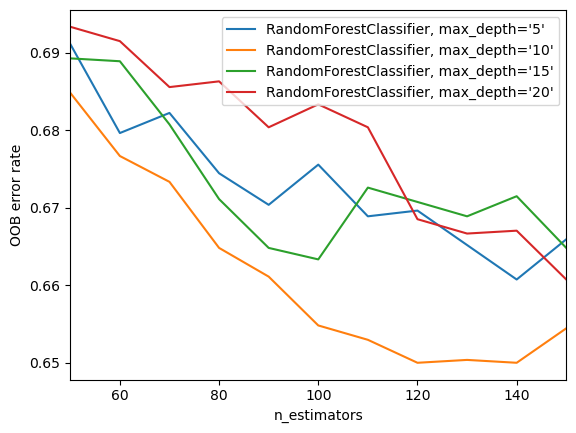

In [52]:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()